# Link prediction challenge

We are using graph-tool (only available in Mac/Linux) and pytorch/dgl (sometimes hard to install). To make sure everything works let's run it on google colab
[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jgarciab/NetworkScience/blob/main/Practicals/day2b_link_prediction.ipynb) 

In [ ]:
## If you are running this on your computer you can install the libraries uncommenting these lines
## Don't mix installations with conda and installations with pip (bad practice)
# conda install -c conda-forge graph-tool
# conda install -c pytorch pytorch
# conda install -c dglteam dgl

In [5]:
# Graph-tool is not available in the standard colab environment so we must first install it...
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [6]:
# Install node2vec to create embeddings
!pip install -U gensim
!pip install node2vec

In [ ]:
# Install libraries of deep neural networks
!pip install torch
!pip install dgl

In [1]:
# networks
import networkx as nx
import graph_tool.all as gt
from graph_tool import topology, inference, generation, stats, correlations, clustering

# machine learning
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

# embeddings
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA, TruncatedSVD, NMF

# Some math
import scipy.sparse as sp
import numpy as np
from numpy.linalg import inv

# data wrangling
import pandas as pd
from itertools import permutations, combinations, product

# viz
import pylab as plt

In [2]:
#path_data = "../NetworkScience/Data/"
#Don't change this on colab
path_data = "./"

## 1. Read network
We are going to use a protein-protein interaction network from S. cervisiae (the yeast that is used to make beer, bread and all sort of yummy things): http://interactome.dfci.harvard.edu/S_cerevisiae/download/YuSci2008.pdf


__You can also try predicting in the Twitter network by editing the network (write "twitter" instead of "ppi")__
```

In [3]:
network = "ppi"

# Read network (download it from internet) 
## ONLY IN COLAB! (otherwise use the data from the Data folder, no need to download)
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction.graphml 
!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction_test.csv

# Path network
path_network = f"{path_data}/{network}_network_prediction.graphml"

# Read to networkx
if network == "ppi":
    G = nx.read_graphml(path_network, node_type=int)
else:
    G = nx.read_graphml(path_network)
# Read to graph-tool
g = gt.load_graph(path_network)
num_vertices = g.num_vertices()
# The node names in graph-tool are different from the ones in networkx
# let's create a dictionary to map graph-tool node labels to networkx node labels
if network == "ppi":
    gt_to_graphml_labels = dict((i, int(g.vp['_graphml_vertex_id'][i])) for i in range(g.num_vertices()))
else:
    gt_to_graphml_labels = dict((i, g.vp['_graphml_vertex_id'][i]) for i in range(g.num_vertices()))


# Initialize dataframe with all node pairs (potential links)
df_all_pairs = pd.DataFrame(permutations(G.nodes(), 2))

# Merge with dataframe with actual links to create dummy variable (link / no link)
df_pos = pd.DataFrame(G.edges())
df_pos["link"] = 1
df_all_pairs = pd.merge(df_all_pairs, df_pos, how="outer")
df_all_pairs["link"] = df_all_pairs["link"].fillna(0) #the ones that were not present in df_pos represent absence of links

display(df_all_pairs.head())

# Read test dataset (we will be testing our predictions on this one. Do not use this data for anything else)
test = pd.read_csv(f"{path_data}/{network}_network_prediction_test.csv", sep="\t", index_col=0)
test.columns = [0,1,"label"]
if network == "twitter":
    test[0] = test[0].astype(str)
    test[1] = test[1].astype(str)
test.head()

--2023-07-10 23:22:32--  https://github.com/jgarciab/NetworkScience/raw/main/Data/ppi_network_prediction.graphml
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ppi_network_prediction.graphml [following]
--2023-07-10 23:22:33--  https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ppi_network_prediction.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111993 (109K) [text/plain]
Saving to: ‘ppi_network_prediction.graphml.1’

ppi_network_predict 100%[===================>] 109,37K  --.-KB/s    in 0,02s   

2023-07-10 23:22:33 (

,0,1,link
0,0,1,1.0
1,0,2,0.0
2,0,439,1.0
3,0,8,1.0
4,0,9,0.0


,0,1,label
0,191,60,1
1,327,409,1
2,152,245,1
3,266,799,1
4,511,26,1


### How does this network look like?

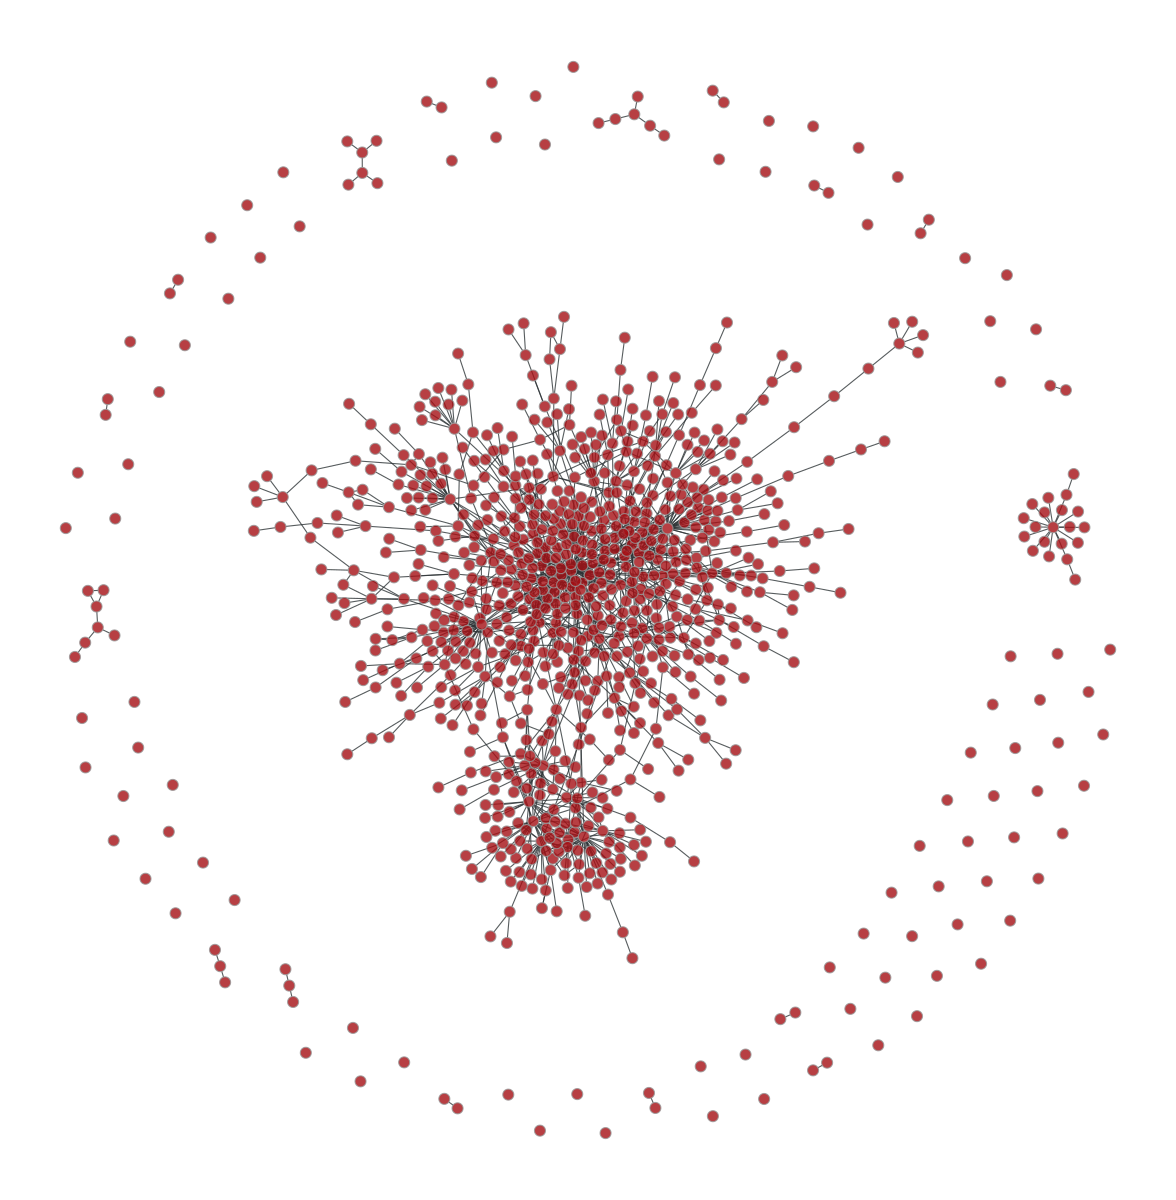

Global clustering:  0.014498356852890006 (0.014498356852890006, 0.003750499964581285)
Degree assortativity:  -0.15721206469700127 (-0.15721206469700144, 0.018677897226418667)


<Figure size 1000x1000 with 0 Axes>

In [4]:
# Plotting the network using graph-tool
plt.figure(figsize=(10,10))
gt.graph_draw(g)

# Calculating the clustering and assotativity using networkx and graph-tool
print("Global clustering: ", nx.transitivity(G), clustering.global_clustering(g, sampled=False))
print("Degree assortativity: ", nx.assortativity.degree_assortativity_coefficient(G), correlations.scalar_assortativity(g, "total"))

In [5]:
def create_predictions(df_all_pairs, df_s, test, return_test = False):
    """
    Train a LogisticRegression given the labels from df_all_pairs and the scores from df_s. 
    The model is evaluated in the test dataset

    df_all_pairs: Columns 0,1,label (label = presence of a link in the training data (the graph))
    df_s: Columns 0,1,variables to use as predictors
    test: Columns 0,1, link (link = presence of a link in the test data (the actual graph))
    """
    # Use all columns except the first two as independent variables (the first two are the labels)
    col_emb = list(df_s.columns)[2:]

    # Merge the labels to the scores to create a model
    df = pd.merge(df_all_pairs, df_s, how="left", validate="1:1")

    # Create model and fit using cross-validation
    model = LogisticRegressionCV(cv=5, max_iter=1000, class_weight="balanced", n_jobs=-1, scoring="f1")
    model.fit(df[col_emb], df["link"])
    print(model.coef_, model.intercept_)

    # Predict labels
    df["pred"] = model.predict(df[col_emb])

    # Merge the predictions with the test dataset to evaluate the prediction
    df_test = pd.merge(test, df)

    #recall = ability of the classifier to find all the positive samples.
    #precision = ability of the classifier not to label as positive a sample that is negative.
    print(classification_report(df_test["label"], df_test["pred"]))

    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, df_test[col_emb], df_test["label"]) 
    plt.plot([0,1], [0,1], "--", color="lightgray", zorder=0)
    plt.grid(True)

    if return_test:
        return df_test
    
    # return predicted probabilities
    return model.predict_proba(df[col_emb])[:,1]



## 2. Methods based on similarity

The following methods calculate node similarity looking mostly at (variations of) common neighbors.

In graph-tool, this is done with the function s_jaccard = gt.vertex_similarity(g, "jaccard"): https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.vertex_similarity



In [6]:
# create dataframe all possible edges (N*(N-1))
edgelist = pd.DataFrame([vi for vi in product(range(g.num_vertices()), repeat=2)])
display(edgelist.head())

# Convert the nodes names to have the same names as we had in networkx
edgelist[0] = edgelist[0].map(gt_to_graphml_labels)
edgelist[1] = edgelist[1].map(gt_to_graphml_labels)
edgelist.head()

,0,1
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


,0,1
0,0,0
1,0,1
2,0,2
3,0,439
4,0,8


In [7]:
# Calculate jaccard similarity, convert to dataframe (cols 0 and 1 are the node ids)
## calculate jaccard similarity and convert to an array
s_jaccard = gt.vertex_similarity(g, "jaccard")

# create a copy of all possible edges
jaccard = edgelist.copy()
# add a column with the jaccard similarity between node pairs
jaccard['score'] = np.array([s_jaccard[i] for i in range(num_vertices)]).reshape(-1)
jaccard['score'] = jaccard['score'].fillna(0) #there are somehow missing values (self-loops, but not only)


## You can change the "jaccard" argument to create a new metric
gt.vertex_similarity?

[[0.72901067]] [-0.00644664]
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       297
           1       0.95      0.13      0.23       297

    accuracy                           0.56       594
   macro avg       0.74      0.56      0.46       594
weighted avg       0.74      0.56      0.46       594



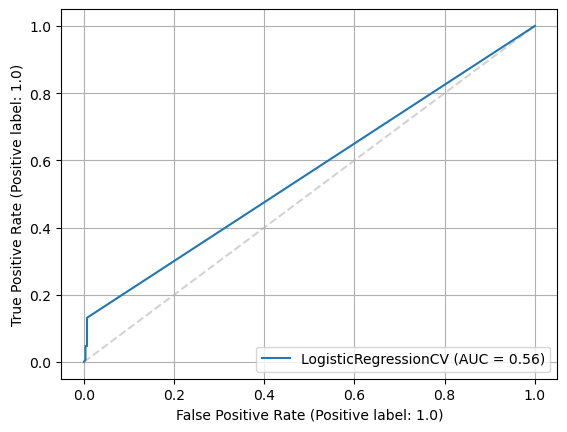

In [8]:
# Create predictions. This function will try to use the columns in the `jaccard` dataframe to predict the link
prob_jac = create_predictions(df_all_pairs, jaccard, test)

# save the probabilities for later (stacking algorithms)
df_all_pairs["jaccard"] = prob_jac

### You can try some methods from here as well
https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

For example maybe nodes link proportionally to their degree

In [9]:
# Calculate pref attachment --> Returns the name of the two nodes, and the product of the degree
pa = nx.preferential_attachment(G, permutations(G.nodes(), 2))
df_pa = pd.DataFrame(list(pa))
df_pa.head()

,0,1,2
0,0,1,612
1,0,2,680
2,0,439,68
3,0,8,408
4,0,9,204


[[0.07109017]] [-1.00092328]
              precision    recall  f1-score   support

           0       0.62      0.93      0.74       297
           1       0.86      0.44      0.58       297

    accuracy                           0.68       594
   macro avg       0.74      0.68      0.66       594
weighted avg       0.74      0.68      0.66       594



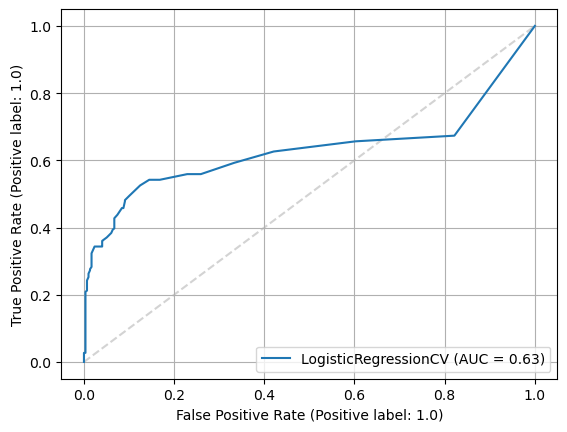

In [10]:
# create predictions as before
prob_jac = create_predictions(df_all_pairs, df_pa, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["pa"] = prob_jac

## 3. Methods based on paths
There are also methods that look not only at immediate neighbors, but also at longer-paths. You can do this using matrix multiplication (remember that A^2 represents the number of paths between i and j in two steps)


[[ 0.35429116  1.13814185 -0.04978321]] [-0.84381647]
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       297
           1       0.89      0.37      0.52       297

    accuracy                           0.66       594
   macro avg       0.75      0.66      0.63       594
weighted avg       0.75      0.66      0.63       594



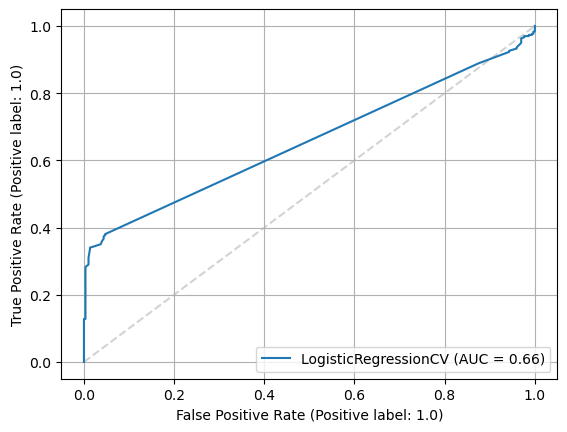

In [11]:
A = nx.to_numpy_array(G)

#Make higher order powers
A2 = (A @ A)
np.fill_diagonal(A2, 0)
A3 = (A2 @ A)
np.fill_diagonal(A3, 0)
A4 = (A3 @ A)
np.fill_diagonal(A4, 0)


# Put it into a nice format
df_longer_paths = edgelist.copy()
df_longer_paths["a2"] = A2.reshape(-1)
df_longer_paths["a3"] = A3.reshape(-1)
df_longer_paths["a4"] = A4.reshape(-1)


# create predictions
prob_jac = create_predictions(df_all_pairs, df_longer_paths, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["paths"] = prob_jac

A more sophisticated method is Katz similarity. The Katz Similarity between two nodes i and j is the sum of the number of walks of all lengths between i and j, but there's a catch: the walks are given exponentially decreasing weights based on their lengths. The intuition is that shorter walks between two nodes indicate a stronger connection.

For some reason it does not work for the PPI network

Largest eigenvalue: (2.000000000000019+0j)


/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

[[0.]] [0.]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       297
           1       0.00      0.00      0.00       297

    accuracy                           0.50       594
   macro avg       0.25      0.50      0.33       594
weighted avg       0.25      0.50      0.33       594



/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/garci061/miniforge3/envs/networks/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarn

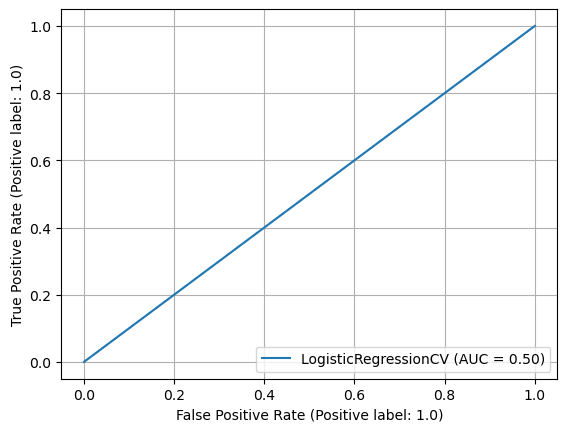

In [12]:
def create_katz(g, beta):
    #Katz score (solving using algebra)
    #beta=decay parameter (paths of longer length are weighted less)
    ks = inv(I - gt.adjacency(g)*beta) - I
    return np.array(ks.real)


# Set \beta to 1/the largest eigenvector of the Laplacian 
# (https://stackoverflow.com/questions/62069781/how-to-find-the-similarity-between-pair-of-vertices-using-katz-index-in-python)
L = gt.laplacian(g, norm=True)
e = np.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))
beta = 1/max(e)
I = np.identity(num_vertices) #create identity matrix

# Calculate katz similarity
ks = create_katz(g, beta)
np.max(ks)

# Put it into a nice format
df_katz = edgelist.copy()
df_katz["katz"] = ks.reshape(-1)

# create predictions
prob_jac = create_predictions(df_all_pairs, df_katz, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["katz"] = prob_jac

## 4. Methods based on node embeddings (spectral methods and matrix factorization; node2vec)
The following methods will create node embeddings based on transformations of the adjacency matrix, and on random walks

In order to predict a link, each pair of embeddings needs to be combined (e.g. by computing the L1 norm (np.abs(v1-v2))


* 4.1 shows an example of a spectral method (you can try different methods: TruncatedSVD, PCA, SpectralEmbedding and NMF; you can modify the dimension of the embedding as well)
* 4.2 shows an example of node2vec (you can change the p and q parameters, the length of walks, etc)




In [13]:
def calculate_dist(v1, v2):
    """
    Calculate the L1 distance between two embeddings
    (you could use a different formula, such as (v1*v2))
    """
    #I'm taking the sum, but you could let a downstream model find that out
    return np.sum(np.abs(v1 - v2))

def create_pair_distance(embeddings, G, fun_distance=calculate_dist):
    """
    Calculates the distance between embeddings using calculate_dist
    """
    # Create dictionary with embeddings
    df_clsvd = pd.DataFrame(embeddings)
    df_clsvd.index = G.nodes()
    df_clsvd = {k: row.values for k,row in df_clsvd.iterrows()}


    # Calculate all distances and convert to dictionary
    pairs = combinations(G.nodes(), 2)
    all_pairs = [fun_distance(df_clsvd[n1], df_clsvd[n2]) for n1,n2 in pairs]

    # Concatenate labels with node pairs      
    all_pairs = pd.DataFrame(all_pairs)
    all_pairs =  pd.concat([pd.DataFrame(combinations(G.nodes(), 2)), all_pairs.reset_index(drop=True)], axis=1)
    all_pairs.columns = [0,1]+[f"_{i}" for i in range(2, len(all_pairs.columns))]

    # Add the reverse of the node pair
    all_pairs = pd.concat([all_pairs, all_pairs.rename(columns={0:1, 1:0})])

    return all_pairs

### 4.1 Example with SVD
Try also PCA, SpectralEmbedding and NMF 

Try different time of embeddings sizes (n_components)

In [14]:
A = nx.to_scipy_sparse_array(G)
clusters_svd = TruncatedSVD(n_components=10)
clusters_svd.fit(A)
cl_svd = clusters_svd.components_.T

# clusters_svd = SpectralEmbedding(affinity = 'precomputed', n_components=5)
# clusters_svd.fit(A)
# cl_svd = clusters_svd.embedding_

In [15]:
df_emb = create_pair_distance(cl_svd, G)
#You can try to modify calculate_dist

[[1.47040248]] [-0.51378377]
              precision    recall  f1-score   support

           0       0.62      0.87      0.72       297
           1       0.78      0.47      0.59       297

    accuracy                           0.67       594
   macro avg       0.70      0.67      0.66       594
weighted avg       0.70      0.67      0.66       594



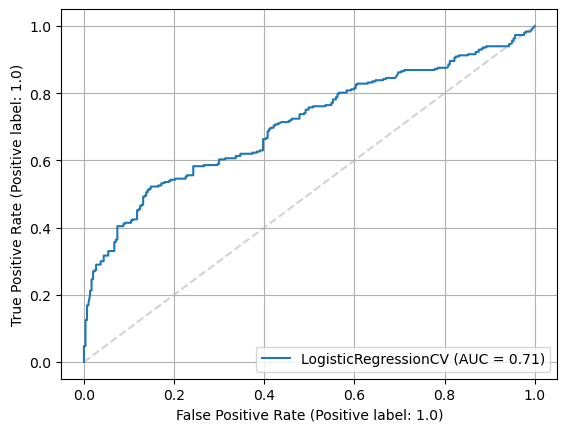

In [16]:
probs = create_predictions(df_all_pairs, df_emb, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["svd"] = probs

## 4.2 Example with node2vec

You can create and save more predictions by changing the q and p parameters

In [17]:
# Generate walks
from node2vec import Node2Vec
import gensim

dimensions = 32
workers = 8
node2vec = Node2Vec(G, dimensions=64, q=0.5, walk_length=30, num_walks=10, workers=8)  


# Embed nodes (dimensions = embedding size)
model = node2vec.fit(window=5, min_count=1, batch_words=4) 
#model = gensim.models.Word2Vec(vector_size = 32, workers=8, window=5, min_count=1, batch_words=4)

# Embeddings as a pandas dataframe
node2vec = pd.DataFrame([model.wv.get_vector(str(_)) for _ in G.nodes()])
node2vec.head()

Computing transition probabilities:   0%|          | 0/964 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.290953,-0.423206,0.137332,0.643605,-0.153030,-0.444788,0.604797,0.335547,-0.438467,-0.289995,...,-0.091424,-0.067881,0.455805,-0.252837,-0.656835,-0.079890,-0.134077,0.069671,-0.062683,-0.677802
1,0.619948,-0.117058,0.141251,0.492055,0.480219,-0.637056,0.335051,0.061535,0.008925,-0.222740,...,-0.162193,0.460687,-0.165005,0.208937,-0.160723,0.084435,-0.281855,-0.157327,0.728389,-0.285380
2,0.869817,-0.266674,-0.243972,0.406817,0.614766,-0.265292,0.384583,0.332982,-0.421742,-0.035704,...,-0.243044,0.192915,0.489299,-0.599998,-0.114034,0.274496,-0.146327,0.134646,-0.278344,0.258209
3,0.237571,-0.377746,0.131836,0.841415,-0.042341,-0.582521,0.412119,0.184931,-0.284472,-0.095769,...,-0.291584,0.066844,0.327020,-0.080117,-0.468061,-0.135988,-0.143540,-0.049687,0.070771,-0.819200
4,0.432792,-0.521278,0.060866,0.587819,-0.168675,-0.106638,0.146559,0.564755,-0.398983,0.250748,...,0.140321,0.229912,0.452430,-0.279671,-0.658722,0.227895,-0.301781,-0.214415,0.055567,-0.460124


In [18]:
# Create all distances
df_emb = create_pair_distance(node2vec, G)

[[-0.54482994]] [10.05861089]
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       297
           1       0.84      0.22      0.34       297

    accuracy                           0.59       594
   macro avg       0.70      0.59      0.52       594
weighted avg       0.70      0.59      0.52       594



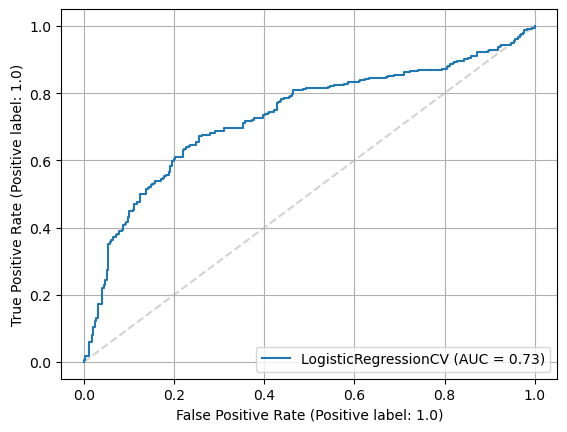

In [19]:
# Caulate predictions
probs = create_predictions(df_all_pairs, df_emb, test)
# save the probabilities for later (stacking algorithms)
df_all_pairs["node2vec"] = probs

# 5. Stacking classifiers
For each method we fitted a logisticregression, which returned a probability of two nodes being connected. 

We can now fit a meta-classifier, which takes those predictions and combines them in order to (hopefully) create a better classifier.

You can try different algorithms apart from LogisticRegressionCV: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


In [20]:
df_preds = df_all_pairs[[0,1]+["jaccard","paths","katz","svd","node2vec","pa"]]
df_preds.head()

,0,1,jaccard,paths,katz,svd,node2vec,pa
0,0,1,0.503248,1.000000,0.5,0.909143,0.602757,1.000000
1,0,2,0.498388,0.969523,0.5,0.918424,0.078215,1.000000
2,0,439,0.498388,0.300732,0.5,0.921848,0.992023,0.978818
3,0,8,0.498388,1.000000,0.5,0.917939,0.876479,1.000000
4,0,9,0.498388,0.131328,0.5,0.919469,0.052928,0.999999


[[-52.53331963   3.90274593   1.60597116   4.28666766  24.94950784
   18.88473951]] [-5.71887635]
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       297
           1       0.94      0.22      0.36       297

    accuracy                           0.60       594
   macro avg       0.75      0.60      0.54       594
weighted avg       0.75      0.60      0.54       594



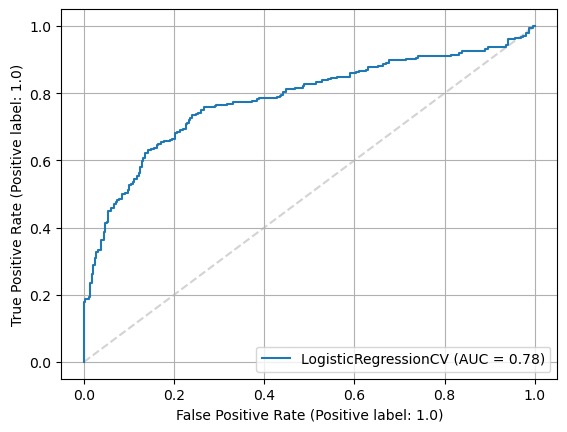

In [21]:
df_test_stack = create_predictions(df_all_pairs, df_preds, test, return_test=True)

In [22]:
#Link prediction is hard!

# 6. Explore some of the node pairs with the highest probability of a link
You can look at our results and explore which proteins may be interacting 

e.g. using the test dataset (you can also find the ones with the highest probability of being a link in the full dataset)

In [23]:
# Create a dictionary to go from the node index to the text label
d_conv_inv = nx.get_node_attributes(G, "label")
df_test_stack["source"] = df_test_stack[0].map(d_conv_inv)
df_test_stack["target"] = df_test_stack[1].map(d_conv_inv)

df_test_stack.loc[(df_test_stack["link"]==0) & (df_test_stack["label"]!=1) &  (df_test_stack["node2vec"] > 0.6)].head(20)

,0,1,label,link,jaccard,pa,paths,katz,svd,node2vec,pred,source,target
316,776,560,0,0.0,0.498388,0.297602,0.224074,0.5,0.393387,0.828770,0.0,YMR298W,YCR021C
319,440,859,0,0.0,0.498388,0.268760,0.300732,0.5,0.470770,0.760941,0.0,YJR057W,YLL017W
345,571,876,0,0.0,0.498388,0.268760,0.300732,0.5,0.374307,0.999939,1.0,YFR027W,YIL051C
375,782,773,0,0.0,0.498388,0.268760,0.300732,0.5,0.374307,0.999935,1.0,YOR028C,YMR117C
376,654,446,0,0.0,0.498388,0.297602,0.807285,0.5,0.479842,0.642776,0.0,YJR022W,YOL143C
401,636,628,0,0.0,0.588570,0.297602,0.053195,0.5,0.376291,0.959285,0.0,YMR059W,YLL049W
422,891,717,0,0.0,0.498388,0.282959,0.290368,0.5,0.445529,0.649546,0.0,YER150W,YNR030W
425,616,511,0,0.0,0.498388,0.268760,0.300732,0.5,0.374307,0.999935,1.0,YMR316W,YJR021C
447,318,899,0,0.0,0.498388,0.328150,0.207239,0.5,0.468291,0.644013,0.0,YDR411C,YDR434W
460,788,453,0,0.0,0.498388,0.268760,0.300732,0.5,0.470770,0.799338,0.0,YPR193C,YOR232W


In [24]:
#d_conv_inv[776], d_conv_inv[560]

https://yeastgenome.org/locus/YMR298W Ceramide synthase subunit; single-span ER membrane protein associated with Lag1p and Lac1p and __required for ceramide synthase activity__, null mutant grows extremely slowly and is defective in ceramide synthesis 1 

https://yeastgenome.org/locus/YCR021C (Heat Shock Protein)  Negative regulator of the H(+)-ATPase Pma1p; stress-responsive protein; hydrophobic plasma membrane localized; induced by heat shock, ethanol treatment, weak organic acid, glucose limitation, and entry into stationary phase 1 2 3 4 5 6 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3974757/
We find that __during heat stress distinct metabolic mechanisms control the abundance of different groups of ceramide species__. Additionally, distinct groups of ceramide species regulated different sets of functionally related genes, indicating that specific sub-groups of lipids participated in different regulatory pathways. These results indicate a previously unrecognized complexity and versatility of lipid-mediated cell regulation.

# 7. Example of Graph Neural Networks (graphSAGE )

The power of GNNs comes from their ability to use the structure of the graph, and the relationships between nodes, to improve their predictions or understanding of the data. They work by updating each node's features based on the features of its neighbors, allowing information to flow across the graph. This is particularly useful when we want to understand the context of a node, as defined by its location within a larger network.

Let's create the data (this is exactly the same code used above, with the same random seed). Don't worry about this code. It's a bit too convoluted.

In [25]:
# Set up a seed for replicbility
np.random.seed(1546)

if network == "ppi":
    # Download network for challenge
    df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
else:
    # Twitter data
    df = pd.read_csv("https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0,1]
    
df = pd.concat([df, df.rename(columns={0:1, 1:0})])
# Create network, remove self-loops, keep largest component
G = nx.from_pandas_edgelist(df, source=0, target=1)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
# Go back to a dataframe and add both directions
df = pd.DataFrame(G0.edges())
df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()
# Convert the labels to integers and go back to a network
nodes = df[0].unique()
d_conv = dict(zip(nodes, range(len(nodes))))
df[0] = df[0].map(d_conv)
df[1] = df[1].map(d_conv)
# Get adjacency matrix
G = nx.from_pandas_edgelist(df, source=0, target=1)
adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))
# Index of elements that are nonzero
u,v = np.nonzero(adj)
eids = np.arange(len(u))
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1) #keep 10% of edges as testing
train_size = len(u) - test_size
# Randomly select some edges for testing and training
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj_neg =  adj.todense() + np.eye(len(G)) - 1
neg_u, neg_v = np.nonzero(adj_neg)
neg_eids = np.random.choice(len(neg_u), len(u))
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# Create test data as dataframe
pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
pos["label"] = 1
neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
neg["label"] = 0
df_test = pd.concat([pos,neg])


In [26]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import dgl
import dgl.nn as dglnn
from sklearn.model_selection import train_test_split
from dgl.data.utils import save_graphs, load_graphs
from dgl import function as fn
from torch.utils.data import DataLoader
import dgl.function as fn
from dgl.nn import SAGEConv
import itertools



In [27]:
# Define the graph
g = dgl.graph((df[0].values, df[1].values))

# Assume node features / labels are the one-hot encoding of the node ID (i.e., no metadata)
g.ndata['feat'] = F.one_hot(g.nodes(), num_classes=g.number_of_nodes()).float()

# Remove edges in the test dataset
train_g = dgl.remove_edges(g, eids[:test_size])

# Training networks (one for positive edges, one for negative)
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

# Testing networks (one for positive edges, one for negative)
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# All possible pairs (to create predictions at the end)
all_neg_g = dgl.graph((neg_u, neg_v), num_nodes=g.number_of_nodes())



In [28]:


# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        """
        in_feats = number of features of the nodes
        h_feats = number of dimensions of the embedding
        """
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Last layer
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']
        
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [29]:
# Set up the model, taking the features and setting the embedding size to 16
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# Last layer (convert embedding to prediction)
pred = MLPPredictor(16)

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(25):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    
    # predict and compute loss
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 1 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            print('AUC in testing', compute_auc(pos_score, neg_score))

    

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    all_negs = pred(all_neg_g, h)
    print('AUC final', compute_auc(pos_score, neg_score))



In epoch 0, loss: 0.6974804997444153
AUC in testing 0.49214932716616216
In epoch 1, loss: 0.6932205557823181
AUC in testing 0.5427790814996202
In epoch 2, loss: 0.690477192401886
AUC in testing 0.6038159371492705
In epoch 3, loss: 0.6879090070724487
AUC in testing 0.6515548300060084
In epoch 4, loss: 0.6839841604232788
AUC in testing 0.6958246890906823
In epoch 5, loss: 0.6780709624290466
AUC in testing 0.7234862655738076
In epoch 6, loss: 0.6698967218399048
AUC in testing 0.7422371866816311
In epoch 7, loss: 0.659166157245636
AUC in testing 0.7550136607375664
In epoch 8, loss: 0.6454064249992371
AUC in testing 0.7649219467401285
In epoch 9, loss: 0.6280608177185059
AUC in testing 0.7740026527905316
In epoch 10, loss: 0.6071912050247192
AUC in testing 0.7820403813669805
In epoch 11, loss: 0.5831329226493835
AUC in testing 0.7900781099434299
In epoch 12, loss: 0.5561291575431824
AUC in testing 0.7976623700529425
In epoch 13, loss: 0.5264698266983032
AUC in testing 0.8039882551667064
In 

In [30]:
df_test["pred"] = np.concatenate([pos_score.numpy(), neg_score.numpy()])
d_conv_inv = {v: k for (k, v) in d_conv.items()}
df_test["source"] = df_test[0].map(d_conv_inv)
df_test["target"] = df_test[1].map(d_conv_inv)


print(classification_report(df_test["label"], df_test["pred"]>0))

df_test.sort_values(by="pred", ascending=False).head(20)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       297
           1       0.74      0.81      0.77       297

    accuracy                           0.76       594
   macro avg       0.77      0.76      0.76       594
weighted avg       0.77      0.76      0.76       594



,0,1,label,pred,source,target
111,380,23,1,4.375009,YML029W,YDR100W
25,391,77,1,4.346211,YOR370C,YML051W
89,77,391,1,4.278520,YML051W,YOR370C
271,59,62,1,4.045922,YMR071C,YDR479C
40,154,49,1,3.901572,YBR261C,YPL049C
12,2,0,1,3.890185,YCR086W,YLR291C
165,23,154,1,3.859999,YDR100W,YBR261C
238,49,225,1,3.815999,YPL049C,YPL031C
96,266,299,0,3.782121,YPL004C,YDR510W
95,138,0,1,3.684121,YOR284W,YLR291C


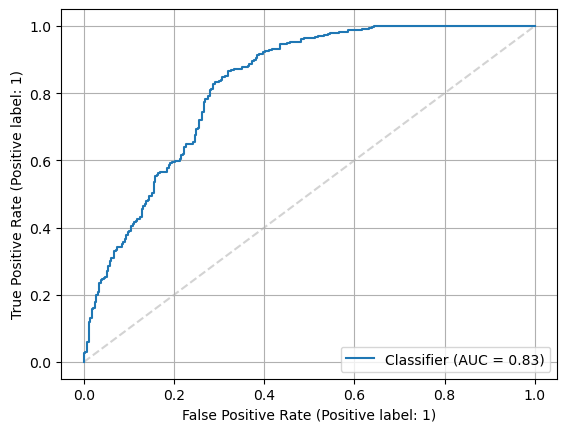

In [31]:
# Plot ROC curve
RocCurveDisplay.from_predictions(df_test["label"], df_test["pred"])
plt.plot([0,1], [0,1], "--", color="lightgray", zorder=0)
plt.grid(True)


In [32]:
# Predictions for all pairs of nodes with no link
df_all_neg = pd.DataFrame([neg_u, neg_v, all_negs.numpy()]).T

# Add back the labels
d_conv_inv = {v: k for (k, v) in d_conv.items()}
df_all_neg["source"] = df_all_neg[0].map(d_conv_inv)
df_all_neg["target"] = df_all_neg[1].map(d_conv_inv)

# Print top
df_all_neg.sort_values(by=2, ascending=False).head(20)


,0,1,2,source,target
161910,169.0,271.0,5.248548,YIR038C,YPL094C
259537,271.0,169.0,5.162403,YPL094C,YIR038C
162000,169.0,371.0,5.137541,YIR038C,YIR033W
162059,169.0,431.0,5.098145,YIR038C,YCR106W
355410,371.0,169.0,5.080871,YIR033W,YIR038C
412971,431.0,169.0,5.063414,YCR106W,YIR038C
162009,169.0,380.0,5.046157,YIR038C,YML029W
355508,371.0,271.0,5.044584,YIR033W,YPL094C
161833,169.0,187.0,5.039448,YIR038C,YDL108W
364031,380.0,169.0,5.035059,YML029W,YIR038C


https://yeastgenome.org/locus/YPL049C
Essential subunit of Sec63 complex; with Sec61 complex, Kar2p/BiP and Lhs1p forms a channel competent for SRP-dependent and post-translational SRP-independent __protein targeting and import into the ER__; cotranslationally N-acetylated by NatA; other members are Sec63p, Sec66p, and Sec72p


https://yeastgenome.org/locus/YML029W
Scaffold subunit of the Hrd1p ubiquitin ligase; also promotes ligase oligomerization; __involved in ER-associated protein degradation (ERAD)__; interacts with the U1 snRNP-specific protein, Snp1p

## This is how we created the network

In [230]:


def create_network_train_test(df, net_name="twitter"):
    df = pd.concat([df, df.rename(columns={0:1, 1:0})])

    G = nx.from_pandas_edgelist(df, source=0, target=1)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    df = pd.DataFrame(G0.edges())
    df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()

    nodes = df[0].unique()
    d_conv = dict(zip(nodes, range(len(nodes))))
    df[0] = df[0].map(d_conv)
    df[1] = df[1].map(d_conv)

    G = nx.from_pandas_edgelist(df, source=0, target=1)

    adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))

    u,v = np.nonzero(adj)
    eids = np.arange(len(u))
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = len(u) - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj_neg =  adj.todense() + np.eye(len(G)) - 1
    neg_u, neg_v = np.nonzero(adj_neg)

    neg_eids = np.random.choice(len(neg_u), len(u))
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    # Positive and negative examples to test (50-50)
    pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
    pos["label"] = 1
    neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
    neg["label"] = 0
    df_test = pd.concat([pos,neg])
    len(df_test)

    df_test.to_csv(f"{path_data}{net_name}_network_prediction_test.csv", sep="\t")

    # Network with 10% removed
    G.remove_edges_from(zip(test_pos_u, test_pos_v))
    nx.set_node_attributes(G, {v:k for k,v in d_conv.items()}, name="label")
    nx.write_graphml(G, f"{path_data}{net_name}_network_prediction.graphml")

if 0: #don't run it
    np.random.seed(1546)
    # Create network for challenge (Twitter)
    df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0,1]
    create_network_train_test(df, net_name="twitter")

    np.random.seed(1546)
    # Create network for challenge (PPI)
    df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
    create_network_train_test(df, net_name="ppi")